In [1]:
! pip install pymvg

  Using cached pymvg-2.1.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached multicamselfcal-0.3.2-py3-none-any.whl
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached pymvg-2.1.0-py3-none-any.whl (28 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)


In [1]:
sequence_key = 'p7s1'
camera_number = 1
calibraton_file_path_base = "./gait3d/Sequences/{sequence_key}/Calibration/c{camera_number}.xml"
calibraton_file_path_1 = calibraton_file_path_base.format(sequence_key=sequence_key, camera_number=1)
print(calibraton_file_path_1)

calibraton_file_path_2 = calibraton_file_path_base.format(sequence_key=sequence_key, camera_number=2)
print(calibraton_file_path_2)

./gait3d/Sequences/p7s1/Calibration/c1.xml
./gait3d/Sequences/p7s1/Calibration/c2.xml


In [2]:
with open(calibraton_file_path_1) as file:
    xml_calibration_config = file.read()
    print(xml_calibration_config)

<?xml version="1.0" encoding="UTF-8"?>
<Camera name="c1">
	<Geometry width="960" height="540" ncx="9.600000e+002" nfx="9.600000e+002" dx="1.000000e+000" dy="1.000000e+000" dpx="1.000000e+000" dpy="1.000000e+000"/>
	<Intrinsic focal="5.561470e+002" kappa1="2.720130e-007" cx="4.800000e+002" cy="2.700000e+002" sx="1.001630e+000"/>
	<Extrinsic tx="2.564550e+001" ty="6.130300e+002" tz="3.444080e+003" rx="-3.121731e+000" ry="1.353192e+000" rz="1.582054e+000"/>
</Camera>



In [194]:
import xml.etree.ElementTree as ET
import numpy as np
from scipy.spatial.transform import Rotation as R

def parse_camera_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    camera_name = root.attrib['name']

    geometry = root.find('Geometry')
    intrinsic = root.find('Intrinsic')
    extrinsic = root.find('Extrinsic')
    
    camera_width = float(geometry.get('width'))
    camera_height = float(geometry.get('height'))

    f = float(intrinsic.get('focal'))
    c = np.array([
        float(intrinsic.get('cx')),
        float(intrinsic.get('cx'))
    ])

    k = np.array([
        float(intrinsic.get('kappa1')), 0.0, 0.0
        # k2=0 and k3=0 - not provided in file 
    ])

    p = np.array([0.0, 0.0])  # p - not provided in file

    T = np.array([
        [float(extrinsic.get("tx"))],
        [float(extrinsic.get("ty"))],
        [float(extrinsic.get("tz"))]
    ]).reshape(3, 1)

    rx, ry, rz = float(extrinsic.get("rx")), float(extrinsic.get("ry")), float(extrinsic.get("rz"))
    R_matrix = R.from_euler('xyz', [rx, ry, rz]).as_matrix()

    return {
        "name": camera_name,
        "width": camera_width,
        "height": camera_height,
        "R": R_matrix,
        "T": T,
        "f": f,
        "c": c,
        "k": k,
        "p": p
    }



In [195]:
parse_camera_xml(calibraton_file_path_1)

{'name': 'c1',
 'width': 960.0,
 'height': 540.0,
 'R': array([[-0.00243038,  0.99995771, -0.0088693 ],
        [ 0.21587739, -0.00813555, -0.97638659],
        [-0.97641746, -0.00428767, -0.21584849]]),
 'T': array([[  25.6455],
        [ 613.03  ],
        [3444.08  ]]),
 'f': 556.147,
 'c': array([480., 480.]),
 'k': array([2.72013e-07, 0.00000e+00, 0.00000e+00]),
 'p': array([0., 0.])}

In [196]:
# code based on https://github.com/microsoft/multiview-human-pose-estimation-pytorch/tree/master

import numpy as np
from pymvg.camera_model import CameraModel
from pymvg.multi_camera_system import MultiCameraSystem


def unfold_camera_param(camera):
    """
    Camera parameters:
        R: 3x3 Camera rotation matrix
        T: 3x1 Camera translation parameters
        f: (scalar) Camera focal length
        c: 2x1 Camera center
        k: 3x1 Camera radial distortion coefficients
        p: 2x1 Camera tangential distortion coefficients
    """
    R = camera['R']
    T = camera['T']
    f = camera['f'] # 0.5 * (camera['fx'] + camera['fy'])
    c = camera['c'] # np.array([camera['cx'], camera['cy']])
    k = camera['k']
    p = camera['p']
    return R, T, f, c, k, p


def build_multi_camera_system(cameras):
    """
    Build a multi-camera system with pymvg package for triangulation

    Args:
        cameras: list of camera parameters
    Returns:
        cams_system: a multi-cameras system
    """
    pymvg_cameras = []
    for camera in cameras:
        R, T, f, c, k, p = unfold_camera_param(camera)
        camera_matrix = np.array(
            [[f, 0, c[0]], [0, f, c[1]], [0, 0, 1]], dtype=float)
        proj_matrix = np.zeros((3, 4))
        proj_matrix[:3, :3] = camera_matrix
        distortion = np.array([k[0], k[1], p[0], p[1], k[2]])
        distortion.shape = (5,)
        T = -np.matmul(R, T)
        M = camera_matrix.dot(np.concatenate((R, T), axis=1))
        camera = CameraModel.load_camera_from_M(
            M, name=camera['name'], distortion_coefficients=distortion,
            width=camera['width'], height=camera['height']
        )
        pymvg_cameras.append(camera)
    return MultiCameraSystem(pymvg_cameras)


def triangulate_one_point(camera_system, points_2d_set):
    """
    Triangulate 3d point in world coordinates with multi-views 2d points

    Args:
        camera_system: pymvg camera system
        points_2d_set: list of structure (camera_name, point2d)
    Returns:
        points_3d: 3x1 point in world coordinates
    """
    points_3d = camera_system.find3d(points_2d_set)
    return points_3d


def triangulate_poses(cameras_params, poses2d):
    """
    Triangulate 3d points in world coordinates of multi-view 2d poses
    by interatively calling $triangulate_one_point$

    Args:
        camera_params: a list of camera parameters, each corresponding to single camera
        poses2d: ndarray of shape nxkx2, len(cameras) == n
    Returns:
        poses3d: ndarray of shape n/nviews x k x 3
    """
    nviews = poses2d.shape[0]
    njoints = poses2d.shape[1]
    ninstances = 1 #len(camera_files_paths)

    poses3d = []
    for i in range(ninstances):
        camera_system = build_multi_camera_system(cameras_params)

        pose3d = np.zeros((njoints, 3))
        for k in range(njoints):
            points_2d_set = []

            for j in range(nviews):
                camera_name = 'c{}'.format(j+1)
                points_2d = poses2d[i * nviews + j, k, :]
                points_2d_set.append((camera_name, points_2d))
            pose3d[k, :] = triangulate_one_point(camera_system, points_2d_set).T
        poses3d.append(pose3d)
    return np.array(poses3d)


In [197]:
from utils.video_tools import get_camera_calibration_files, get_video_files

sequence_key = "p7s1"

camera_files_paths = get_camera_calibration_files(sequence_key)
cameras_params = [parse_camera_xml(camera_path) for camera_path in camera_files_paths]
cameras_params

[{'name': 'c1',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.00243038,  0.99995771, -0.0088693 ],
         [ 0.21587739, -0.00813555, -0.97638659],
         [-0.97641746, -0.00428767, -0.21584849]]),
  'T': array([[  25.6455],
         [ 613.03  ],
         [3444.08  ]]),
  'f': 556.147,
  'c': array([480., 480.]),
  'k': array([2.72013e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c2',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.99988253, -0.01426695,  0.00560169],
         [-0.00739992,  0.12928686, -0.99157962],
         [ 0.0134226 , -0.9915046 , -0.12937724]]),
  'T': array([[ -61.8235],
         [ 618.076 ],
         [5233.55  ]]),
  'f': 554.64,
  'c': array([480., 480.]),
  'k': array([4.60719e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c3',
  'width': 960.0,
  'height': 540.0,
  'R': array([[ 0.01244236, -0.99987309,  0.00994977],
         [-0.22203888, -0.01246488, -0.97495813],
         [ 0.97495842,  0.009

In [198]:
mcs = build_multi_camera_system(cameras_params)
mcs

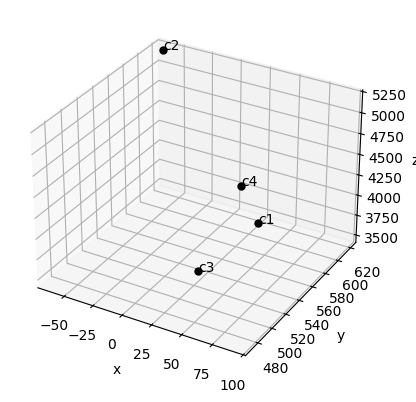

In [220]:
from pymvg.plot_utils import plot_system
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot_system( ax, mcs )
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
# ax.set_xlim(-0.8,0.8); ax.set_ylim(-0.8,0.8); ax.set_zlim(-0.8,0.8)
plt.show()

In [204]:
video_files = get_video_files(sequence_key)
video_files

['./gait3d/Sequences/p7s1/Images/c1_0090.avi',
 './gait3d/Sequences/p7s1/Images/c2_0090.avi',
 './gait3d/Sequences/p7s1/Images/c3_0090.avi',
 './gait3d/Sequences/p7s1/Images/c4_0090.avi']

In [205]:
from scripts.frame_iterator import video_frame_iterator
from scripts.frame_iterator import video_frame_iterator

frames_iterator = [video_frame_iterator(avi_file) for avi_file in video_files]
mp_estimators = [MediaPipeEstimator() for _ in range(4)]
predicted = [{} for _ in range(4)]
MAX_FRAMES = 80

for frame_i in range(MAX_FRAMES):
    for iter_ind, (f_iterator, mp_estimator) in enumerate(zip(frames_iterator, mp_estimators)):
        frame_ts, frame = next(f_iterator)
        estimations = mp_estimator.predict_for_frame(frame_ts, frame)
        predicted[iter_ind][frame_i] = estimations

I0000 00:00:1743448093.931028   37127 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1743448093.958819   42748 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
W0000 00:00:1743448094.010217   42761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743448094.094499   42758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1743448094.095273   37127 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1743448094.106293   42762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
W0000 00:00:1743448094.153121   42769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

[Frame 0] Landmarks not found!
[Frame 40] Landmarks not found!
[Frame 80] Landmarks not found!
[Frame 120] Landmarks not found!
[Frame 160] Landmarks not found!
[Frame 200] Landmarks not found!
[Frame 240] Landmarks not found!
[Frame 280] Landmarks not found!
[Frame 320] Landmarks not found!
[Frame 360] Landmarks not found!
[Frame 400] Landmarks not found!
[Frame 440] Landmarks not found!
[Frame 480] Landmarks not found!
[Frame 520] Landmarks not found!
[Frame 560] Landmarks not found!
[Frame 600] Landmarks not found!
[Frame 640] Landmarks not found!
[Frame 680] Landmarks not found!
[Frame 720] Landmarks not found!
[Frame 760] Landmarks not found!
[Frame 800] Landmarks not found!
[Frame 840] Landmarks not found!
[Frame 880] Landmarks not found!
[Frame 920] Landmarks not found!
[Frame 960] Landmarks not found!
[Frame 1000] Landmarks not found!
[Frame 1040] Landmarks not found!
[Frame 1080] Landmarks not found!
[Frame 1120] Landmarks not found!
[Frame 1160] Landmarks not found!
[Frame 12

In [206]:
predicted[0][0]

[(811, 130),
 (813, 125),
 (814, 124),
 (815, 124),
 (812, 125),
 (813, 124),
 (813, 124),
 (824, 122),
 (821, 123),
 (817, 135),
 (815, 135),
 (858, 154),
 (822, 153),
 (861, 201),
 (816, 198),
 (852, 244),
 (810, 231),
 (852, 256),
 (807, 242),
 (845, 255),
 (807, 242),
 (844, 251),
 (808, 240),
 (840, 236),
 (818, 233),
 (825, 297),
 (812, 292),
 (818, 352),
 (806, 346),
 (822, 363),
 (811, 357),
 (790, 358),
 (780, 350)]

In [207]:
predicted[3][0]

[]

In [208]:
sample_2d_points = np.array([predicted[i][70] for i in [0,1,2,3]])
sample_2d_points.shape

(4, 33, 2)

In [209]:
sample_result = triangulate_poses(cameras_params, sample_2d_points)
sample_result

array([[[-6.55587450e+01,  6.36902342e+02,  4.55758513e+03],
        [-6.69308380e+01,  6.34688492e+02,  4.55674897e+03],
        [-6.66197570e+01,  6.34217553e+02,  4.55676341e+03],
        [-6.60975502e+01,  6.33619448e+02,  4.55679213e+03],
        [-6.77684234e+01,  6.35186334e+02,  4.55670804e+03],
        [-6.83949245e+01,  6.35701878e+02,  4.55647479e+03],
        [-6.86055716e+01,  6.36200253e+02,  4.55627356e+03],
        [-6.52094283e+01,  6.31056621e+02,  4.55655230e+03],
        [-6.82474897e+01,  6.33639338e+02,  4.55600908e+03],
        [-6.43648515e+01,  6.37476237e+02,  4.55812814e+03],
        [-6.54076888e+01,  6.37236398e+02,  4.55798961e+03],
        [-4.89736272e+01,  6.30202450e+02,  4.55987950e+03],
        [-6.42584269e+01,  6.35245540e+02,  4.55904867e+03],
        [-2.91312278e+01,  6.35904381e+02,  4.56610424e+03],
        [-5.07948105e+01,  6.39960326e+02,  4.56507835e+03],
        [-2.18176876e+01,  6.48917576e+02,  4.56941481e+03],
        [-4.57408523e+01

In [210]:
x = sample_result[0, :, 0]
y = sample_result[0, :, 1]
z = sample_result[0, :, 2]
x

array([-65.55874502, -66.93083799, -66.61975702, -66.09755017,
       -67.7684234 , -68.39492446, -68.60557156, -65.20942827,
       -68.24748967, -64.36485154, -65.40768882, -48.97362724,
       -64.25842688, -29.13122777, -50.79481055, -21.81768764,
       -45.74085231, -19.60102253, -44.93104963, -20.90713375,
       -44.85328315, -21.49078858, -43.55414296, -23.6398326 ,
       -35.14086091, -18.00739773, -16.94436121,   7.0536312 ,
         2.81077864,  13.20363567,  12.46721322,   9.48205853,
        -0.08277054])

In [211]:
y

array([636.90234166, 634.68849157, 634.21755278, 633.6194482 ,
       635.18633356, 635.70187825, 636.20025272, 631.05662116,
       633.63933815, 637.47623737, 637.23639789, 630.20245035,
       635.24554031, 635.90438107, 639.96032586, 648.91757637,
       650.51336359, 652.55494311, 652.3582991 , 653.58671759,
       652.84477265, 653.31376735, 652.3959631 , 643.10477007,
       646.1833901 , 655.32341781, 662.4726166 , 653.80773979,
       661.84021297, 649.59062883, 658.15334369, 670.75892104,
       681.49789485])

In [212]:
z

array([4557.58513224, 4556.74897017, 4556.763412  , 4556.79212755,
       4556.70803934, 4556.47479199, 4556.27355908, 4556.55230007,
       4556.00907539, 4558.12814098, 4557.98961072, 4559.87949802,
       4559.04867442, 4566.10423641, 4565.07834689, 4569.41480793,
       4568.48290367, 4570.72154271, 4569.6670422 , 4570.10041771,
       4569.60683825, 4569.88207912, 4568.99013199, 4567.89593501,
       4567.86433846, 4571.46343988, 4572.08286926, 4578.09008777,
       4578.10364713, 4580.60485657, 4580.33368501, 4577.10878513,
       4578.08182249])

In [213]:
import mediapipe as mp
mp_pose = mp.solutions.pose
landmarks_num = 33

pose_landmark_names = {i: mp_pose.PoseLandmark(i).name for i in range(landmarks_num)}
connections = list(mp_pose.POSE_CONNECTIONS)

print(pose_landmark_names)
print(connections)

{0: 'NOSE', 1: 'LEFT_EYE_INNER', 2: 'LEFT_EYE', 3: 'LEFT_EYE_OUTER', 4: 'RIGHT_EYE_INNER', 5: 'RIGHT_EYE', 6: 'RIGHT_EYE_OUTER', 7: 'LEFT_EAR', 8: 'RIGHT_EAR', 9: 'MOUTH_LEFT', 10: 'MOUTH_RIGHT', 11: 'LEFT_SHOULDER', 12: 'RIGHT_SHOULDER', 13: 'LEFT_ELBOW', 14: 'RIGHT_ELBOW', 15: 'LEFT_WRIST', 16: 'RIGHT_WRIST', 17: 'LEFT_PINKY', 18: 'RIGHT_PINKY', 19: 'LEFT_INDEX', 20: 'RIGHT_INDEX', 21: 'LEFT_THUMB', 22: 'RIGHT_THUMB', 23: 'LEFT_HIP', 24: 'RIGHT_HIP', 25: 'LEFT_KNEE', 26: 'RIGHT_KNEE', 27: 'LEFT_ANKLE', 28: 'RIGHT_ANKLE', 29: 'LEFT_HEEL', 30: 'RIGHT_HEEL', 31: 'LEFT_FOOT_INDEX', 32: 'RIGHT_FOOT_INDEX'}
[(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28), (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)]


In [214]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'iframe'

labels = list(pose_landmark_names.values())

def show_3d_pose(x, y, z, labels, connections):
    x_lines = []
    y_lines = []
    z_lines = []
    
    for i, j in connections:
        x_lines += [x[i], x[j], None]
        y_lines += [y[i], y[j], None]
        z_lines += [z[i], z[j], None]
        
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(size=3, color='blue'),
                text=labels,
                hoverinfo='text',
                name='Joints'),
            go.Scatter3d(
                x=x_lines, y=y_lines, z=z_lines,
                mode='lines',
                line=dict(color='royalblue', width=2),
                name='Bones'),
            ]
    )
    
    
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube', 
    ),
    title='3D joints plot from bvh file',
    width=800,
    height=800
    )
    
    fig.show()

In [215]:
show_3d_pose(x, y, z, labels, connections)

In [216]:
frame_num = 10

views_with_points = []
for i in range(4):
    if predicted[i][frame_num]:
        views_with_points.append(i)

print(f"{views_with_points = }")
sample_camera_params = [cameras_params[i] for i in views_with_points]

sample_2d_points = np.array([predicted[i][70] for i in views_with_points])
sample_2d_points.shape

views_with_points = [0, 1, 2]


(3, 33, 2)

In [217]:
sample_camera_params

[{'name': 'c1',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.00243038,  0.99995771, -0.0088693 ],
         [ 0.21587739, -0.00813555, -0.97638659],
         [-0.97641746, -0.00428767, -0.21584849]]),
  'T': array([[  25.6455],
         [ 613.03  ],
         [3444.08  ]]),
  'f': 556.147,
  'c': array([480., 480.]),
  'k': array([2.72013e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c2',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.99988253, -0.01426695,  0.00560169],
         [-0.00739992,  0.12928686, -0.99157962],
         [ 0.0134226 , -0.9915046 , -0.12937724]]),
  'T': array([[ -61.8235],
         [ 618.076 ],
         [5233.55  ]]),
  'f': 554.64,
  'c': array([480., 480.]),
  'k': array([4.60719e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c3',
  'width': 960.0,
  'height': 540.0,
  'R': array([[ 0.01244236, -0.99987309,  0.00994977],
         [-0.22203888, -0.01246488, -0.97495813],
         [ 0.97495842,  0.009

In [218]:
sample_result = triangulate_poses(cameras_params, sample_2d_points)
sample_result

array([[[-181.05615388,  838.18454286, 4222.99061872],
        [-183.07619072,  840.69557845, 4220.92132175],
        [-183.24339403,  840.56220535, 4220.91007852],
        [-183.40895844,  840.4288629 , 4220.89881558],
        [-182.04611711,  839.22130647, 4221.3596229 ],
        [-182.04277524,  839.77689606, 4220.98996318],
        [-181.95970045,  839.44880053, 4220.98801616],
        [-183.50418424,  837.02978493, 4221.32488613],
        [-182.32271605,  835.82293873, 4221.36491565],
        [-181.97891842,  835.44254725, 4224.73947339],
        [-181.78700966,  834.26220852, 4224.80867421],
        [-174.00827792,  812.99012339, 4233.00131855],
        [-180.84176789,  810.7422824 , 4232.9162999 ],
        [-151.56822694,  786.79975812, 4248.70415297],
        [-164.59126369,  782.28070697, 4248.73863904],
        [-141.30381952,  770.92838215, 4260.11921439],
        [-157.50884057,  762.58579205, 4260.78153144],
        [-138.6070841 ,  765.99555617, 4263.89765267],
        [-

In [219]:
x = sample_result[0, :, 0]
y = sample_result[0, :, 1]
z = sample_result[0, :, 2]

show_3d_pose(x, y, z, labels, connections)